# 6. Decision Trees and Ensemble Learning
This week, we´ll talk about decision trees and tree-based ensemble algorithms

## 6.1 Credit risk scoring project
- Dataset: https://github.com/gastonstat/CreditScoring

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## 6.2 Data cleaning and preparation

- Downloading the dataset
- Re-encoding the categorical variables
- Doing the train/validation/test split

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

In [3]:
!wget $data

--2024-05-16 20:51:58--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv.1’

CreditScoring.csv.1 100%[===================>] 178.21K  --.-KB/s    in 0.06s   

2024-05-16 20:51:59 (3.13 MB/s) - ‘CreditScoring.csv.1’ saved [182489/182489]



In [4]:
!head CreditScoring.csv

"Status","Seniority","Home","Time","Age","Marital","Records","Job","Expenses","Income","Assets","Debt","Amount","Price"
1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
1,0,1,36,26,1,1,1,46,107,0,0,310,910
1,1,2,60,36,2,1,1,75,214,3500,0,650,1645
1,29,2,60,44,2,1,1,75,125,10000,0,1600,1800
1,9,5,12,27,1,1,1,35,80,0,0,200,1093
1,0,2,60,32,2,1,3,90,107,15000,0,1200,1957


In [5]:
df = pd.read_csv(data)

In [6]:
df.columns = df.columns.str.lower()

In [7]:
df.status.value_counts()

status
1    3200
2    1254
0       1
Name: count, dtype: int64

In [8]:
status_values = {
    1: 'ok', 
    2: 'default', 
    0: 'unk'
}

df.status = df.status.map(status_values)

In [9]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime', 
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [10]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [11]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan).max()

In [12]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,959.0,300000.0,30000.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,0.0,0.0,0.0,475.0,628.0
min,0.0,6.0,18.0,35.0,959.0,300000.0,30000.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,959.0,300000.0,30000.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,959.0,300000.0,30000.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,959.0,300000.0,30000.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [13]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [14]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [15]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [16]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [17]:
del df_train['status']
del df_val['status']
del df_test['status']

In [18]:
df_train

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,959.0,300000.0,30000.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,959.0,300000.0,30000.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,959.0,300000.0,30000.0,1320,1600
3,1,parents,48,23,single,no,partime,35,959.0,300000.0,30000.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,959.0,300000.0,30000.0,1100,1897
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,18,private,36,45,married,no,fixed,45,959.0,300000.0,30000.0,800,1600
2668,7,private,60,29,married,no,fixed,60,959.0,300000.0,30000.0,1000,1290
2669,1,parents,24,19,single,no,fixed,35,959.0,300000.0,30000.0,400,600
2670,15,owner,48,43,married,no,freelance,60,959.0,300000.0,30000.0,2500,2976


## 6.3 Decision trees

- How a decision tree looks like
- Training a decision tree
- Overfitting
- Controlling the size of a tree

In [19]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else: 
            return 'default'

In [20]:
xi = df_train.iloc[0].to_dict()

In [21]:
assess_risk(xi)

'ok'

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [23]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [24]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [25]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [26]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [27]:
y_pred = dt.predict_proba(X_val)[:, 1]

In [28]:
roc_auc_score(y_val, y_pred)

0.6337004431958538

In [29]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

In [30]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [31]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.7054989859726213
val: 0.6685264343319367


In [32]:
from sklearn.tree import export_text

In [33]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1



## 6.4 Decision tree learning algorithm

- Finding the best split for one column
- Finding the best split for the entire dataset
- Stopping criteria
- Decision tree learning algorithm

In [34]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [35]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [36]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [37]:
from IPython.display import display

In [38]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]

    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))

    print()



0


,assets,status
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64



In [39]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [40]:
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [41]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

In [42]:
for feature, Ts in thresholds.items():
    print('#####################')
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        print()
    print('#####################')


#####################
assets
0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

#####################
#####################
debt
500


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64

1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64

#####################


## 6.5 Decision trees parameter tuning
- selecting max_depth
- selecting min_samples_leaf

In [43]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print('%4s -> %.3f' % (d, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.713
   4 -> 0.719
   5 -> 0.738
   6 -> 0.746
  10 -> 0.676
  15 -> 0.635
  20 -> 0.632
None -> 0.630


In [44]:
scores = []

for d in [4, 5, 6, 7, 10, 15, 20, None]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, s, auc))

In [45]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,min_samples_leaf,auc
0,4.0,1,0.718991
1,4.0,2,0.718991
2,4.0,5,0.718991
3,4.0,10,0.718991
4,4.0,15,0.717093


In [46]:
df_scores.sort_values(by='auc', ascending=False).head()

,max_depth,min_samples_leaf,auc
33,7.0,100,0.750775
24,6.0,100,0.747297
23,6.0,20,0.746958
18,6.0,1,0.746219
69,NaN,100,0.745698


In [47]:
df_scores

,max_depth,min_samples_leaf,auc
0,4.0,1,0.718991
1,4.0,2,0.718991
2,4.0,5,0.718991
3,4.0,10,0.718991
4,4.0,15,0.717093
...,...,...,...
67,NaN,15,0.730943
68,NaN,20,0.729920
69,NaN,100,0.745698
70,NaN,200,0.742619


In [48]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', 
                                  columns=['max_depth'],
                                  values=['auc'])

df_scores_pivot.round(3)

auc                                                 
max_depth           NaN   4.0    5.0    6.0    7.0    10.0   15.0   20.0
min_samples_leaf                                                        
1                 0.636  0.719  0.738  0.746  0.739  0.679  0.641  0.637
2                 0.666  0.719  0.738  0.743  0.721  0.687  0.664  0.661
5                 0.686  0.719  0.736  0.745  0.733  0.703  0.691  0.691
10                0.717  0.719  0.735  0.742  0.729  0.717  0.716  0.717
15                0.731  0.717  0.729  0.740  0.730  0.729  0.730  0.726
20                0.730  0.718  0.732  0.747  0.740  0.727  0.730  0.730
100               0.746  0.726  0.734  0.747  0.751  0.746  0.746  0.746
200               0.743  0.725  0.735  0.743  0.743  0.743  0.743  0.743
500               0.674  0.674  0.674  0.674  0.674  0.674  0.674  0.674

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

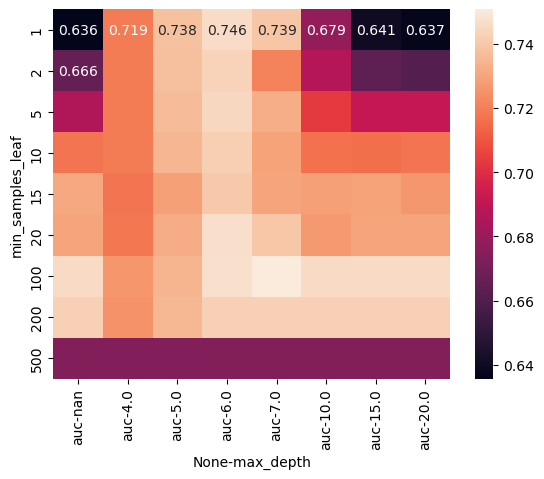

In [49]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [50]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

## 6.6 Ensembles and random forest

- Board of experts
- Ensembling models
- Random forest - ensembling decision trees
- Tuning random forest

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [53]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7367979705020464

In [54]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))

In [55]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

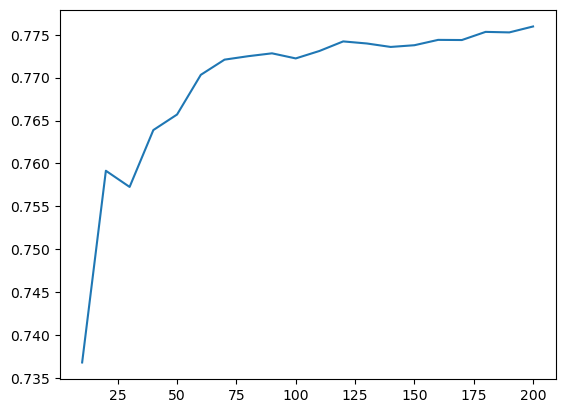

In [56]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [57]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n, auc))

In [58]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.759663
1,5,20,0.768721
2,5,30,0.771748
3,5,40,0.774451
4,5,50,0.774291


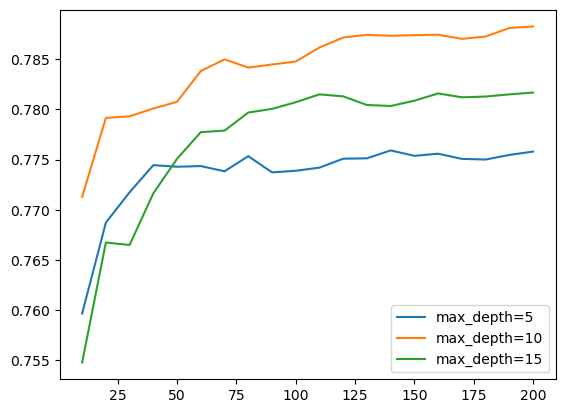

In [59]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [60]:
max_depth = 10

In [61]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((s, n, auc))

In [62]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,min_samples_leaf,n_estimators,auc
0,1,10,0.771285
1,1,20,0.779156
2,1,30,0.779319
3,1,40,0.780094
4,1,50,0.780766


In [63]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
min_samples_leaf_values = [1, 3, 5, 10, 50]
list(zip(min_samples_leaf_values, colors))

[(1, 'black'), (3, 'blue'), (5, 'orange'), (10, 'red'), (50, 'grey')]

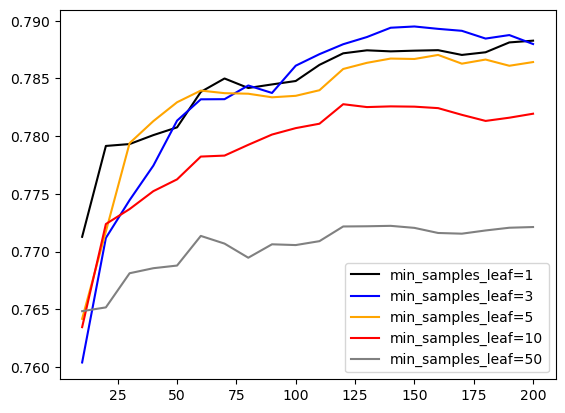

In [64]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
min_samples_leaf_values = [1, 3, 5, 10, 50]

for s, col in zip(min_samples_leaf_values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [65]:
min_samples_leaf = 3

In [66]:
rf = RandomForestClassifier(n_estimators=100,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1,
                            n_jobs=-1)

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_jobs=-1,
                       random_state=1)

Other useful parameters:
- max_features
- bootstrap

## 6.7 Gradient boosting and XGBoost
- Gradient boosting vs random forest
- Installing XGBost
- Training the first model
- Performance monitoring
- Parsing xgboost´s monitoring output

In [67]:
!pip install xgboost

In [68]:
import xgboost as xgb

In [69]:
features = dv.get_feature_names_out()
features_list = features.tolist()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features_list)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features_list)

In [70]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [71]:
y_pred = model.predict(dval)

In [72]:
roc_auc_score(y_val, y_pred)

0.7822346274006442

In [73]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [74]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [75]:
s = output.stdout

In [76]:
print(s)

[0]	train-auc:0.83711	val-auc:0.74863
[5]	train-auc:0.90081	val-auc:0.77563
[10]	train-auc:0.92639	val-auc:0.78258
[15]	train-auc:0.94489	val-auc:0.78252
[20]	train-auc:0.95515	val-auc:0.78016
[25]	train-auc:0.96577	val-auc:0.78002
[30]	train-auc:0.97352	val-auc:0.77848
[35]	train-auc:0.97828	val-auc:0.77813
[40]	train-auc:0.98349	val-auc:0.77636
[45]	train-auc:0.98738	val-auc:0.77460
[50]	train-auc:0.98967	val-auc:0.77341
[55]	train-auc:0.99229	val-auc:0.77389
[60]	train-auc:0.99420	val-auc:0.76954
[65]	train-auc:0.99611	val-auc:0.76851
[70]	train-auc:0.99681	val-auc:0.77051
[75]	train-auc:0.99734	val-auc:0.76850
[80]	train-auc:0.99821	val-auc:0.76759
[85]	train-auc:0.99884	val-auc:0.76555
[90]	train-auc:0.99901	val-auc:0.76662
[95]	train-auc:0.99931	val-auc:0.76497
[100]	train-auc:0.99952	val-auc:0.76389
[105]	train-auc:0.99957	val-auc:0.76530
[110]	train-auc:0.99971	val-auc:0.76537
[115]	train-auc:0.99974	val-auc:0.76504
[120]	train-auc:0.99979	val-auc:0.76428
[125]	train-auc:0.9998

In [77]:
line = s.split('\n')[0]

In [78]:
num_iter, train_auc, val_auc = line.split('\t')

In [79]:
int(num_iter.strip('[]'))

0

In [80]:
float(train_auc.split(':')[1])

0.83711

In [81]:
float(val_auc.split(':')[1])

0.74863

In [82]:
def parse_xbg_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))

    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results


In [83]:
df_score = parse_xbg_output(output)

In [84]:
df_score

,num_iter,train_auc,val_auc
0,0,0.83711,0.74863
1,5,0.90081,0.77563
2,10,0.92639,0.78258
3,15,0.94489,0.78252
4,20,0.95515,0.78016
5,25,0.96577,0.78002
6,30,0.97352,0.77848
7,35,0.97828,0.77813
8,40,0.98349,0.77636
9,45,0.98738,0.77460


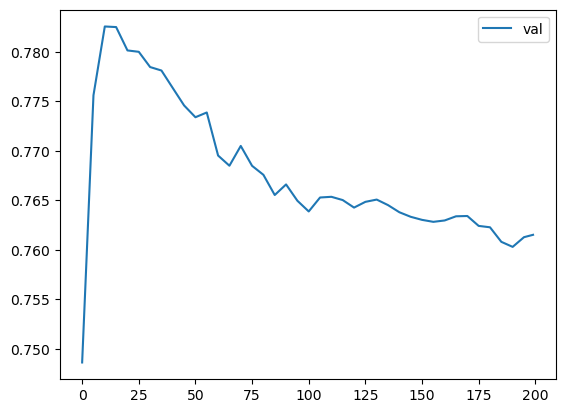

In [85]:
# plt.plot(df_score.num_iter. df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

## 6.8 XGBoost parameter tuning
Tuning the following parameters:

- eta
- max_depth
- min_child_weight

In [86]:
scores = {}

In [87]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [88]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xbg_output(output)
key

'eta=0.1'

In [89]:
scores = {}

In [90]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [91]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xbg_output(output)
key

'max_depth=3'

In [92]:
del scores['max_depth=10']

KeyError: 'max_depth=10'

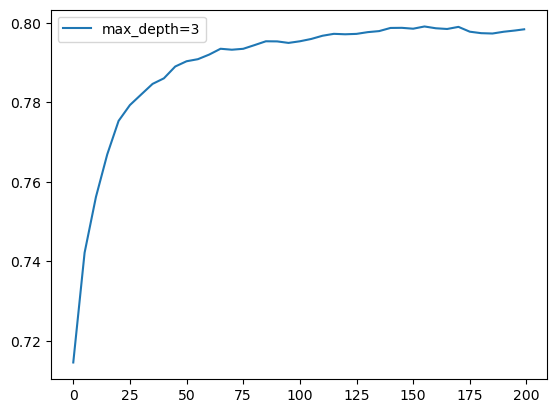

In [93]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

#plt.ylim(0.8, 0.84)
plt.legend()

In [94]:
scores = {}

In [95]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [96]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xbg_output(output)
key

'min_child_weight=30'

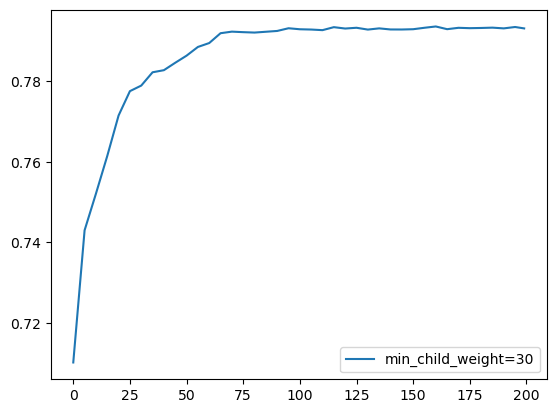

In [97]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

#plt.ylim(0.8, 0.84)
plt.legend()

In [98]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175) 

Other parameters: https://xgboost.readthedocs.io/en/latest/parameter.html 

Useful ones:

- `subsample` and colsample_bytree
- lambda and alpha

## 6.9 Selecting the final model

- Choosing between xgboost, random forest and decision tree
- Training the final model
- Saving the model

In [99]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [100]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7406759342229541

In [101]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [102]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7879834588651281

In [103]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175) 

In [104]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.7977555641665254

In [105]:
df_full_train = df_full_train.reset_index(drop=True)

In [106]:
y_full_train = (df_full_train.status == 'default').astype(int).values

In [107]:
del df_full_train['status']

In [108]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [109]:
features = dv.get_feature_names_out()
features_list = features.tolist()
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                         feature_names=features_list)

dtest = xgb.DMatrix(X_test, feature_names=features_list)

In [110]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175) 

In [111]:
y_pred = model.predict(dtest)

In [112]:
roc_auc_score(y_test, y_pred)

TypeError: missing a required argument: 'y_score'